# Thư viện

In [1]:
%pip install ray

Note: you may need to restart the kernel to use updated packages.


In [4]:
# 1. Import các thư viện cần thiết
from typing import List, Tuple, Dict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import flwr as fl
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from collections import OrderedDict
import seaborn as sns
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị
import ray

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {fl.__version__} / PyTorch {torch.__version__}")


Training on cpu
Flower 1.13.0 / PyTorch 2.5.1


# Dữ liệu

In [5]:
NUM_CLIENTS = 5
BATCH_SIZE = 32

In [6]:
# Hàm làm sạch văn bản
def clean_text(text: str) -> str:
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Xóa URL
    text = re.sub(r"@\w+|#\w+", "", text)  # Xóa mentions và hashtags
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Xóa ký tự đặc biệt
    text = text.lower()  # Chuyển về chữ thường
    text = text.strip()  # Loại bỏ khoảng trắng thừa
    return text

# Đọc và làm sạch dữ liệu
print("Đang đọc dữ liệu...")
df = pd.read_csv("data/spam_ham_dataset.csv").dropna()
print(f"Dữ liệu ban đầu: {df.shape[0]} mẫu.")
print("Trước khi làm sạch:")
print(df['text'].head())

df['text'] = df['text'].apply(clean_text)

print("Sau khi làm sạch:")
print(df['text'].head())

# Encode nhãn
print("Đang mã hóa nhãn...")
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Chia dữ liệu thành train/test
print("Đang chia dữ liệu thành tập train/test...")
train_data, test_data = train_test_split(
    df[['text', 'label']], test_size=0.2, random_state=42
)
print(f"Train: {train_data.shape[0]} mẫu, Test: {test_data.shape[0]} mẫu.")

Đang đọc dữ liệu...
Dữ liệu ban đầu: 5171 mẫu.
Trước khi làm sạch:
0    Subject: enron methanol ; meter # : 988291\r\n...
1    Subject: hpl nom for january 9 , 2001\r\n( see...
2    Subject: neon retreat\r\nho ho ho , we ' re ar...
3    Subject: photoshop , windows , office . cheap ...
4    Subject: re : indian springs\r\nthis deal is t...
Name: text, dtype: object
Sau khi làm sạch:
0    subject enron methanol  meter   988291\r\nthis...
1    subject hpl nom for january 9  2001\r\n see at...
2    subject neon retreat\r\nho ho ho  we  re aroun...
3    subject photoshop  windows  office  cheap  mai...
4    subject re  indian springs\r\nthis deal is to ...
Name: text, dtype: object
Đang mã hóa nhãn...
Đang chia dữ liệu thành tập train/test...
Train: 4136 mẫu, Test: 1035 mẫu.


## Biểu đồ dữ liệu

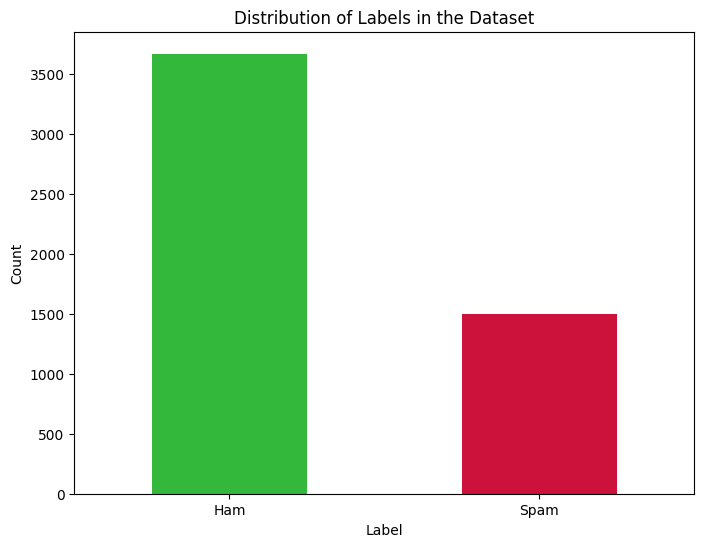

In [11]:
# Tính toán số lượng mỗi nhãn
label_counts = df['label'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['#33B83B', '#CC123B'])
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

In [7]:
print("Train label distribution:\n", train_data['label'].value_counts())
print("Test label distribution:\n", test_data['label'].value_counts())

Train label distribution:
 label
0    2930
1    1206
Name: count, dtype: int64
Test label distribution:
 label
0    742
1    293
Name: count, dtype: int64


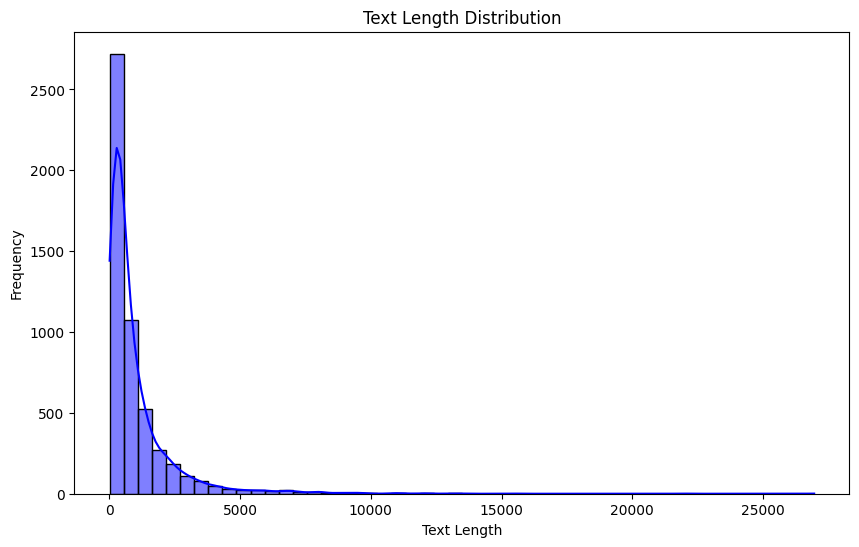

In [12]:
# Tính độ dài văn bản
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True, color='blue', bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


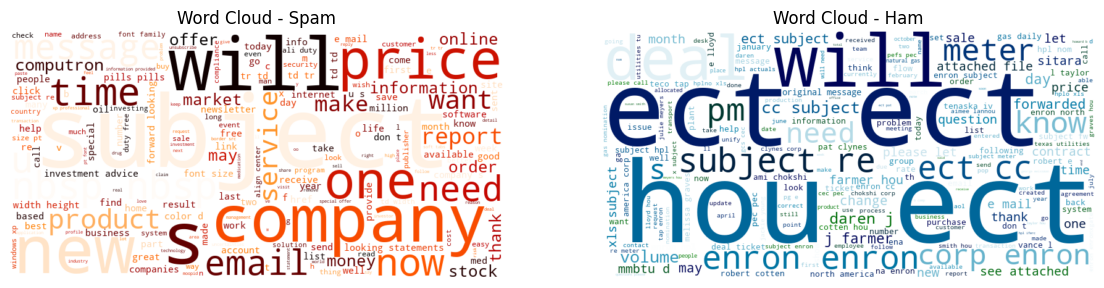

In [17]:
from wordcloud import WordCloud

# Tạo WordCloud cho spam và ham
spam_text = ' '.join(df[df['label'] == 1]['text'])
ham_text = ' '.join(df[df['label'] == 0]['text'])

plt.figure(figsize=(14, 7))

# WordCloud cho Spam
plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='gist_heat').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Word Cloud - Spam")
plt.axis('off')

# WordCloud cho Ham
plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='ocean').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("Word Cloud - Ham")
plt.axis('off')

plt.show()


# Bert Model

## Dữ liệu cho model

In [7]:
# Dataset tùy chỉnh
class SpamDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['label']
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Hàm chia dữ liệu và tạo DataLoader cho từng client
def load_datasets(train_data, test_data, client_id, tokenizer):
    """
    Chia dữ liệu huấn luyện và kiểm tra dựa trên client_id.
    
    Args:
        train_data (pd.DataFrame): Dữ liệu huấn luyện.
        test_data (pd.DataFrame): Dữ liệu kiểm tra.
        client_id (int): ID của client hiện tại.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer BERT.
        num_clients (int): Tổng số client.
    
    Returns:
        train_loader (DataLoader): DataLoader cho tập huấn luyện.
        test_loader (DataLoader): DataLoader cho tập kiểm tra.
    """
    # Kiểm tra nếu client_id hợp lệ
    if client_id >= NUM_CLIENTS or client_id < 0:
        raise ValueError(f"client_id phải nằm trong khoảng từ 0 đến {NUM_CLIENTS-1}")

    # Chia dữ liệu cho client
    train_partition = np.array_split(train_data, NUM_CLIENTS)[client_id]
    test_partition = np.array_split(test_data, NUM_CLIENTS)[client_id]

    # Tạo Dataset và DataLoader cho train và test
    train_dataset = SpamDataset(train_partition, tokenizer)
    test_dataset = SpamDataset(test_partition, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return train_loader, test_loader

# Tạo tokenizer BERT một lần duy nhất
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Lấy DataLoader cho client 0 (ví dụ)
train_loader, test_loader = load_datasets(train_data, test_data, client_id=0, tokenizer=tokenizer)

c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Model

In [9]:
# Định nghĩa mô hình BertNet
class BertNet(nn.Module):
    def __init__(self, model_name: str = 'bert-base-uncased', num_labels: int = 2):
        super(BertNet, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits
    

In [10]:
def train(model, train_loader, optimizer, criterion, device, epochs=2):
    model.train()
    for epoch in range(epochs):
        correct, total = 0, 0
        epoch_loss = 0.0

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for batch in tepoch:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()

                # Update progress bar
                tepoch.set_postfix(loss=epoch_loss / total, accuracy=correct / total)

        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total
        print(f"Epoch {epoch+1}: Train loss {avg_loss:.4f}, Accuracy {accuracy:.4f}")

In [11]:
# Hàm kiểm tra
def test(model, test_loader, criterion, device):
    model.eval()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    loss /= len(test_loader)
    accuracy = correct / total
    return loss, accuracy

In [12]:
# Huấn luyện mô hình
# Khởi tạo mô hình, optimizer và criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = BertNet('bert-base-uncased').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Huấn luyện mô hình
for epoch in range(1):
    print(f"Epoch {epoch+1} started")
    train(net, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1} completed\n")

# Kiểm tra trên tập test
test_loss, test_accuracy = test(net, test_loader, criterion, device)
print(f"Final test set performance:\n\tLoss: {test_loss}\n\tAccuracy: {test_accuracy}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 started


Epoch 1/2: 100%|██████████| 130/130 [34:48<00:00, 16.07s/batch, accuracy=0.943, loss=0.039]


Epoch 1: Train loss 0.1551, Accuracy 0.9432


Epoch 2/2: 100%|██████████| 130/130 [34:02<00:00, 15.71s/batch, accuracy=0.989, loss=0.00826]


Epoch 2: Train loss 0.0329, Accuracy 0.9889
Epoch 1 completed

Final test set performance:
	Loss: 0.03587035254829309
	Accuracy: 0.9864734299516909


In [131]:
# Lưu mô hình sau khi huấn luyện
model_path = "bert_model.pth"

In [ ]:
# Chỉ lưu tham số mô hình
torch.save(net.state_dict(), model_path)
print(f"Mô hình đã được lưu tại: {model_path}")


Mô hình đã được lưu tại: bert_model.pth


## Đánh giá mô hình

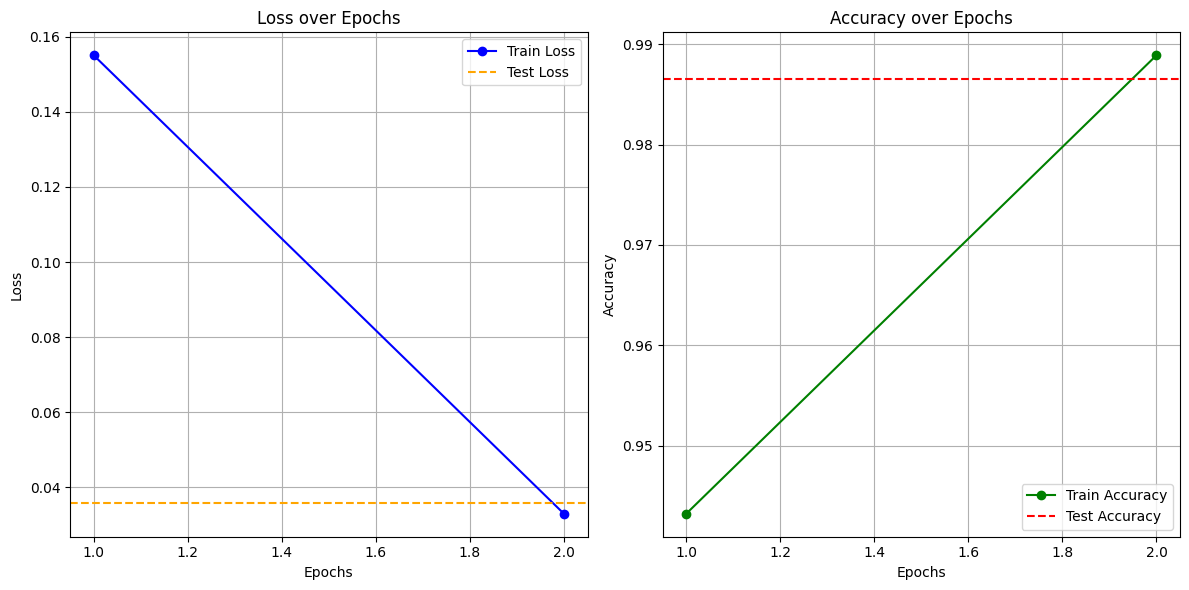

In [13]:
import matplotlib.pyplot as plt

# Dữ liệu giả định cho ví dụ (có thể thay bằng dữ liệu thực tế từ quá trình huấn luyện)
epochs = [1, 2]
train_losses = [0.1551, 0.0329]  # Loss trên tập train
train_accuracies = [0.9432, 0.9889]  # Accuracy trên tập train
test_loss = 0.0359  # Loss trên tập test
test_accuracy = 0.9865  # Accuracy trên tập test

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='blue')
plt.axhline(y=test_loss, color='orange', linestyle='--', label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', color='green')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Federated with Flower

In [14]:
# Kiểm tra dữ liệu cho từng client
for client_id in range(NUM_CLIENTS):
    print(f"Client {client_id + 1}:")
    
    # Lấy DataLoader cho client hiện tại
    train_loader, test_loader = load_datasets(train_data, test_data, client_id, tokenizer)
    
    # Kiểm tra số lượng mẫu trong train_loader và test_loader
    print(f"  Train_loader: {len(train_loader.dataset)} mẫu")
    print(f"  Test_loader: {len(test_loader.dataset)} mẫu")

print("Chia dữ liệu thành công!")


Client 1:
  Train_loader: 828 mẫu
  Test_loader: 207 mẫu
Client 2:
  Train_loader: 827 mẫu
  Test_loader: 207 mẫu
Client 3:
  Train_loader: 827 mẫu
  Test_loader: 207 mẫu
Client 4:
  Train_loader: 827 mẫu
  Test_loader: 207 mẫu
Client 5:
  Train_loader: 827 mẫu
  Test_loader: 207 mẫu
Chia dữ liệu thành công!


In [15]:
# Hàm cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    """
    Cập nhật tham số mô hình từ danh sách numpy array.
    """
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v).to(net.device) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Hàm lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    """
    Trích xuất tham số mô hình dưới dạng danh sách numpy array.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [16]:
# Định nghĩa FlowerClient
class FlowerClient(NumPyClient):
    def __init__(self, net, train_loader, test_loader, device):
        self.net = net.to(device)  # Đưa mô hình vào thiết bị
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

        # Cấu hình optimizer và loss function
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=1e-5)
        self.criterion = torch.nn.CrossEntropyLoss()

    def get_parameters(self, config):
        """Lấy tham số mô hình."""
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.train_loader, self.optimizer, self.criterion, self.device, epochs=1)
        return get_parameters(self.net), len(self.train_loader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.test_loader, self.criterion, self.device)
        return float(loss), len(self.test_loader), {"accuracy": float(accuracy)}


In [ ]:
# Hàm tạo client cho Flower
def client_fn(context: Context) -> Client:
    """
    Tạo một Flower Client với dữ liệu riêng biệt dựa trên client_id.
    """
    net = BertNet('bert-base-uncased').to(device)

    client_id = context.node_config["partition-id"]
    print(f"Client {client_id} has been initialized.")

    # Tải dữ liệu cho client hiện tại
    train_loader, test_loader = load_datasets(
        client_id=client_id,
        train_data=train_data,  
        test_data=test_data,
        tokenizer=tokenizer     
    )

    # Khởi tạo Flower Client với mô hình BERT và dữ liệu đã tải
    return FlowerClient(net, train_loader, test_loader, device=DEVICE).to_client()


In [18]:
# Các tham số toàn cục
NUM_CLIENTS =5  # Số lượng client
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Thiết bị

# Khởi tạo các dữ liệu train, test ở đây (df đã được làm sạch từ trước)
train_data, test_data = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42)

# Tạo Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tạo DataLoader cho client (ở đây client_id=0 để lấy dữ liệu cho client đầu tiên)
train_loader, test_loader = load_datasets(train_data, test_data, client_id=0, tokenizer=tokenizer)

c:\Users\LENOVO\anaconda3\envs\spam_email_detect\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """
    Tính toán trung bình trọng số của các chỉ số accuracy trên nhiều client.
    
    Args:
        metrics (List[Tuple[int, Metrics]]): Danh sách các tuple, mỗi tuple chứa số lượng ví dụ và một dictionary chứa các chỉ số (ví dụ: accuracy).
    
    Returns:
        Metrics: Một dictionary với chỉ số accuracy tính theo trung bình trọng số.
    """
    # Tính toán trọng số (accuracy * số lượng ví dụ)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Tính toán và trả về chỉ số trung bình trọng số
    return {"accuracy": sum(accuracies) / sum(examples)}


In [20]:
# 7. Server Function
def server_fn(context: Context) -> ServerAppComponents:
    
    def log_round_start(round_number: int):
        print(f"=== Starting Round {round_number} ===")
        print(f"Client ID: {context.node_config.get('client_id')}")

    def log_round_end(round_number: int, results):
        print(f"Round {round_number} completed with results: {results}")

    
    strategy = FedAvg(
        fraction_fit=1.0,  # 100% clients tham gia huấn luyện
        fraction_evaluate=0.5, # 50% clients tham gia đánh giá
        min_fit_clients=5,  # Tối thiểu 5 clients tham gia huấn luyện
        min_evaluate_clients=2, # Tối thiểu 2 clients tham gia đánh giá
        min_available_clients=5,   # Tối thiểu 5 clients có sẵn
        evaluate_metrics_aggregation_fn=weighted_average # Hàm tính toán trung bình trọng số
    )
    
    # Gắn các hàm logging cho chiến lược
    strategy.on_round_begin = log_round_start
    strategy.on_round_end = log_round_end
    
    config = ServerConfig(num_rounds=1)
    return ServerAppComponents(strategy=strategy, config=config)


In [21]:
# Cấu hình tài nguyên
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1.0

In [22]:
import os

# Disable oneDNN custom operations to avoid floating-point round-off errors
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import TensorFlow and other required libraries
import tensorflow as tf

# Initialize TensorFlow
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [ ]:

# 8. Chạy mô phỏng
server = ServerApp(server_fn=server_fn)
client = ClientApp(client_fn=client_fn)
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    verbose_logging=True
)

DEBUG 2024-11-24 22:11:20,683:     Asyncio event loop already running.
DEBUG 2024-11-24 22:11:20,684:     Logger propagate set to False
DEBUG 2024-11-24 22:11:20,685:     Pre-registering run with id 3682086608846175929
DEBUG 2024-11-24 22:11:20,686:     Using InMemoryState
DEBUG 2024-11-24 22:11:20,686:     Using InMemoryState
INFO 2024-11-24 22:11:20,687:      Starting Flower ServerApp, config: num_rounds=1, no round_timeout
DEBUG 2024-11-24 22:11:20,688:     Buffer time delay: 5s
INFO 2024-11-24 22:11:20,689:      
INFO 2024-11-24 22:11:20,693:      [INIT]
INFO 2024-11-24 22:11:20,925:      Requesting initial parameters from one random client
DEBUG 2024-11-24 22:11:25,705:     Using InMemoryState
DEBUG 2024-11-24 22:11:25,706:     Registered 5 nodes
DEBUG 2024-11-24 22:11:25,707:     Supported backends: ['ray']
DEBUG 2024-11-24 22:11:25,707:     Initialising: RayBackend
DEBUG 2024-11-24 22:11:25,707:     Backend config: {'client_resources': {'num_cpus': 1, 'num_gpus': 0.0}, 'init_arg